## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import time

## Загружаем исходные данные

In [4]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

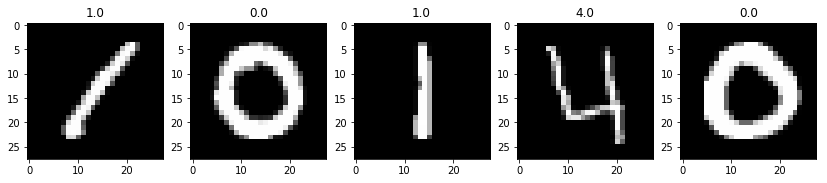

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

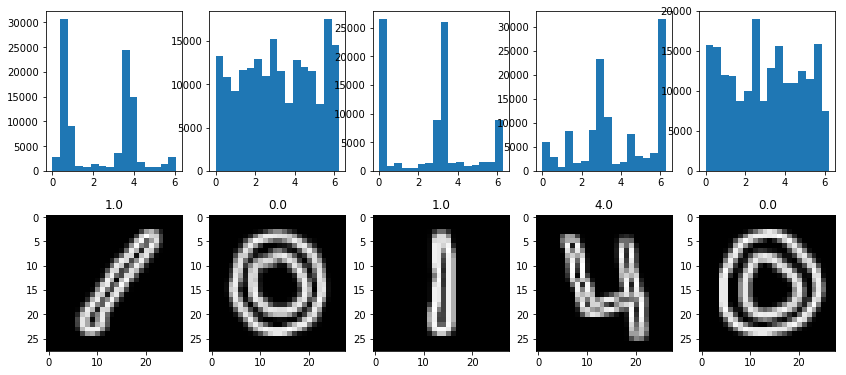

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
#bins = 16
train_hist = np.zeros((len(train_img), 10))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=10,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 10))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=10,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 9 классов

In [15]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [16]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [17]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.42630952381


### Попробуем применить градиентный бустинг

In [24]:
LEARNING_RATE = 0.05
MAX_DEPTH = 5
SUBSAMPLE = 0.75
MAX_FEATURES = 0.5
LEAF = 8
gb_estimator = GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)
gb_estimator.fit(x_train, y_train)
pred_val = gb_estimator.predict(x_val)
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.603571428571


### на каггле дает точность: 0.647619047619

### применим преобразования к данным: угол 0-pi, разное количество binов в гистаграме, поворот гистаграмы таким образом, чтобы в начале стояло максимальное значение

In [51]:
def cycle_arr_to_max(ar):
    maxind = np.argmax(ar)
    ar = ar[maxind : len(ar)] + ar[0: maxind]
    return ar
def divide_arr_in_four(arr):
    shape = arr.shape
    arr_divided = [arr[0:int(shape[0]/2), 0:int(shape[1]/2)],
                        arr[int(shape[0]/2 + 1):shape[0], 0:int(shape[1]/2)],
                        arr[0:int(shape[0]/2), int(shape[1]/2 + 1):shape[1]],
                        arr[int(shape[0]/2 + 1):shape[0], int(shape[1]/2+1):shape[1]]]
    return arr_divided
def convert_to_hist(img, theta, g, hist_bins, range_max, cycle, norm):
    hists = np.zeros((len(img), 4*hist_bins))
    theta_normed = theta % range_max
    
    for i in range(len(img)):
        theta_divided = divide_arr_in_four(theta_normed[i])
        g_divided = divide_arr_in_four(g[i])
        hist_stacked = []
        for j in range(len(theta_divided)):
            hist, borders = np.histogram(theta_divided[j],
                                 bins=hist_bins,
                                 range=(0., range_max),
                                 weights=g_divided[j])
            hist_stacked.extend(hist)
        if cycle:
            hists[i] = cycle_arr_to_max(hist_stacked.tolist())
        else: hists[i] = hist_stacked
    # По умолчанию используется L2 норма
    if norm:
        hists = hists / np.linalg.norm(hists, axis=1)[:, None]
    return hists
def get_hist_predictions(hist_bins, cycle, range_max, norm):
    prev_time = time.time()
    train_hist = convert_to_hist(train_img, train_theta, train_g, hist_bins, range_max, cycle, norm)
    test_hist = convert_to_hist(test_img, test_theta, test_g, hist_bins, range_max, cycle, norm)
    y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)
    LEARNING_RATE = 0.05
    MAX_DEPTH = 5
    SUBSAMPLE = 0.75
    MAX_FEATURES = 0.5
    LEAF = 8
    gb_estimator = GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)
    gb_estimator.fit(x_train, y_train)
    pred_val = gb_estimator.predict(x_val)
    print('Accuracy: %s' % accuracy_score(y_val, pred_val),
          'time=',time.time() - prev_time, 
          'hist_bins=', hist_bins, 'cycle=',cycle,'range_max=',range_max)
    return pred_val, gb_estimator.predict(test_hist)

In [79]:
hist_bins = [5, 10, 15, 20, 25,30]
cycles=[False, True]
max_ranges = [np.pi, 2. * np.pi]
norm = True
for hist_bin in hist_bins:
    for max_range in max_ranges:
        for cycle in cycles:
            get_hist_predictions(hist_bin, cycle, max_range, norm)

Accuracy: 0.508571428571 time= 28.437000036239624 hist_bins= 5 cycle= False range_max= 3.141592653589793
Accuracy: 0.397857142857 time= 28.444000005722046 hist_bins= 5 cycle= True range_max= 3.141592653589793
Accuracy: 0.479880952381 time= 27.842000007629395 hist_bins= 5 cycle= False range_max= 6.283185307179586
Accuracy: 0.381904761905 time= 27.28700017929077 hist_bins= 5 cycle= True range_max= 6.283185307179586
Accuracy: 0.562142857143 time= 40.651000022888184 hist_bins= 10 cycle= False range_max= 3.141592653589793
Accuracy: 0.436071428571 time= 40.812999963760376 hist_bins= 10 cycle= True range_max= 3.141592653589793
Accuracy: 0.605357142857 time= 40.08500003814697 hist_bins= 10 cycle= False range_max= 6.283185307179586
Accuracy: 0.42369047619 time= 40.28200006484985 hist_bins= 10 cycle= True range_max= 6.283185307179586
Accuracy: 0.564523809524 time= 49.132000207901 hist_bins= 15 cycle= False range_max= 3.141592653589793
Accuracy: 0.442619047619 time= 49.76900005340576 hist_bins= 1

In [52]:
best_hist_bin = 20
best_max_range = 2. * np.pi
best_cycle = False
best_norm = False
pred_val, pred_test = get_hist_predictions(best_hist_bin, best_cycle, best_max_range, best_norm)

Accuracy: 0.961785714286 time= 219.33980894088745 hist_bins= 20 cycle= False range_max= 6.283185307179586


### Итого градиетный бустинг с преобразованиями, подобранными с помощью валидации на каггле дает точность 0.96157

(поворот гистаграм к максимальному элементу - только ухудшает качество, также как и изменение угла от 0 до pi)

### подберем преобразование данных для оценки через центройд

In [21]:
def get_hist_predictions_centroid(hist_bins, cycle, range_max, norm):
    prev_time = time.time()
    train_hist = convert_to_hist(train_img, train_theta, train_g, hist_bins, range_max, cycle, norm)
    test_hist = convert_to_hist(test_img, test_theta, test_g, hist_bins, range_max, cycle, norm)
    y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)
    centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)
    for i in range(10):
        centroids[i] = np.mean(x_train[y_train == i], axis=0)
    pred_val = np.zeros_like(y_val)
    for i in range(len(y_val)):
        distances = np.linalg.norm(centroids - x_val[i], axis=1)
        pred_val[i] = np.argmin(distances)
    
    print('Accuracy: %s' % accuracy_score(y_val, pred_val),
          'time=',time.time() - prev_time, 
          'hist_bins=', hist_bins, 'cycle=',cycle,'range_max=',range_max, "norm=",norm)
    pred_test = np.zeros(len(test_img), np.uint8)
    for i in range(len(test_img)):
        distances = np.linalg.norm(centroids - test_hist[i], axis=1)
        pred_test[i] = np.argmin(distances)
    return pred_val, pred_test

In [56]:
hist_bins = [5, 10, 15, 20, 25,30]
cycles=[False, True]
max_ranges = [np.pi, 2. * np.pi]
for hist_bin in hist_bins:
    for max_range in max_ranges:
        for cycle in cycles:
            for norm in cycles:
                get_hist_predictions_centroid(hist_bin, cycle, max_range, norm)

Accuracy: 0.769523809524 time= 24.22385287284851 hist_bins= 5 cycle= False range_max= 3.141592653589793 norm= False
Accuracy: 0.756904761905 time= 24.982110023498535 hist_bins= 5 cycle= False range_max= 3.141592653589793 norm= True
Accuracy: 0.769523809524 time= 24.09964680671692 hist_bins= 5 cycle= True range_max= 3.141592653589793 norm= False
Accuracy: 0.756904761905 time= 24.193158626556396 hist_bins= 5 cycle= True range_max= 3.141592653589793 norm= True
Accuracy: 0.783095238095 time= 23.015072107315063 hist_bins= 5 cycle= False range_max= 6.283185307179586 norm= False
Accuracy: 0.787976190476 time= 23.176151752471924 hist_bins= 5 cycle= False range_max= 6.283185307179586 norm= True
Accuracy: 0.783095238095 time= 22.757306337356567 hist_bins= 5 cycle= True range_max= 6.283185307179586 norm= False
Accuracy: 0.787976190476 time= 22.992121934890747 hist_bins= 5 cycle= True range_max= 6.283185307179586 norm= True
Accuracy: 0.798571428571 time= 24.11575484275818 hist_bins= 10 cycle= Fals

In [57]:
best_hist_bin = 15
best_max_range = 2. * np.pi
best_cycle = False
best_norm = True
pred_val, pred_test = get_hist_predictions_centroid(best_hist_bin, best_cycle, best_max_range, best_norm)

Accuracy: 0.835595238095 time= 23.70572543144226 hist_bins= 15 cycle= False range_max= 6.283185307179586 norm= True


### Классификация через центройд с подобранным преобразованием данных дает на каггле точность 0.83

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.47      0.44      0.45       816
        1.0       0.97      0.96      0.97       909
        2.0       0.52      0.49      0.50       846
        3.0       0.65      0.69      0.67       937
        4.0       0.76      0.72      0.74       839
        5.0       0.65      0.67      0.66       702
        6.0       0.50      0.52      0.51       785
        7.0       0.87      0.81      0.84       893
        8.0       0.54      0.59      0.56       835
        9.0       0.71      0.73      0.72       838

avg / total       0.67      0.67      0.67      8400



In [29]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[339   6  79  27  28  17 123  12 155  30]
 [  4 873   1   0  18   0   1   7   0   5]
 [ 56   0 404 128   7  96  52  15  73  15]
 [ 19   0 101 634   0  87   9   4  75   8]
 [ 23  14  11   4 583   1  86  28   7  82]
 [ 11   0  77 103   0 455   8   7  37   4]
 [142   1  56  12  72   8 367   8  74  45]
 [ 10   2  36   5  38   9  23 710   8  52]
 [125   0  39  47  12  45  35   4 493  35]
 [ 43   2  26  13  50   4  62  25  31 582]]


## Предсказания на тестовыйх данных

In [266]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

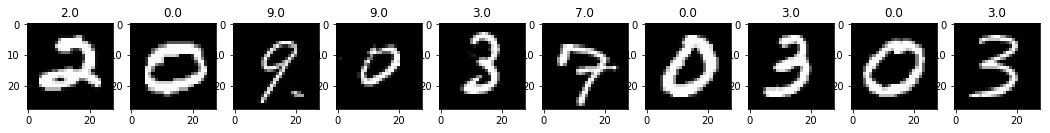

In [53]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1,11, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [58]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [270]:
# Your submission scored 0.41700